In [1]:
#: the usual imports
import babypandas as bpd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

def normal_curve(x, mu=0, sigma=1):
    return 1 / np.sqrt(2*np.pi) * np.exp(-(x - mu)**2/(2 * sigma**2))

def plot_sample_mean(sample_size):
    sample = flights.sample(sample_size).get('Delay')

    fig, ax1 = plt.subplots()
    plt.xlim([-10, 80])
    plt.grid('off')
    ax1.hist(sample, density=True, bins=np.arange(0, 200, 5), label='Sample')
    ax2 = ax1.twinx()
    plot_clt_curve(sample_size)
    ax1.set_ylim([-.0, .055])
    ax2.set_ylim([-.01, .5])

    plt.scatter(sample.mean(), 0, marker='^', color='C1', s=200, label='Sample Mean')
    plt.legend(loc='upper right')

plt.style.use('fivethirtyeight')

# Lecture 22

## Central Limit Theorem and Normal Confidence Intervals

## The Central Limit Theorem

> The distribution of sums (and averages) of large random samples (w/ replacement) are roughly normal, regardless of the distribution of the population from which the sample was drawn.

## Example: Scratch-off lottery tickets

- Table below shows the odds of each prize amount for a lottery ticket

In [2]:
lottery = bpd.DataFrame().assign(
    Prize=[0, 1, 5, 20, 50],
    Odds=[.4, .3, .2, .05, .05]
)
lottery

,Prize,Odds
0,0,0.40
1,1,0.30
2,5,0.20
3,20,0.05
4,50,0.05


## Calculate Gain or Loss

- Each ticket costs $5; subtract from Prize
- Very non-normal distribution

In [3]:
payout = lottery.assign(GainLoss=lottery.get('Prize') - 5)
payout

,Prize,Odds,GainLoss
0,0,0.40,-5
1,1,0.30,-4
2,5,0.20,0
3,20,0.05,15
4,50,0.05,45


## Simulating one lottery ticket

- Choose a payout according to odds.
- `np.random.choice` accepts an array of probabilities.

In [4]:
# randomly choose a payout according to odds
np.random.choice(payout.get('GainLoss'), p=payout.get('Odds'))

-5

## Simulating 100 tickets

- How much do you win/lose after buying 100 tickets?

In [5]:
gl = np.array(payout.get('GainLoss'))
odds = np.array(payout.get('Odds'))

def buy_k_tickets(k):
    winnings = np.array([])

    for i in np.arange(k):
        won = np.random.choice(gl, p = odds)
        winnings = np.append(winnings, won)
        
    return winnings

In [6]:
buy_k_tickets(100).sum() #a sample sum

-220.0

## Repeating the experiment

- After purchasing 100 tickets, your total winnings are a number.
- But it could have been different...
- Total winnings come from some distribution.
- We can approximate it through simulation.

## Repeating the experiment

In [7]:
distribution = np.array([])
n_repetitions = 1000

for i in np.arange(n_repetitions):
    winnings = buy_k_tickets(100).sum()
    distribution = np.append(distribution, winnings)

## Visualizing

<AxesSubplot:ylabel='Frequency'>

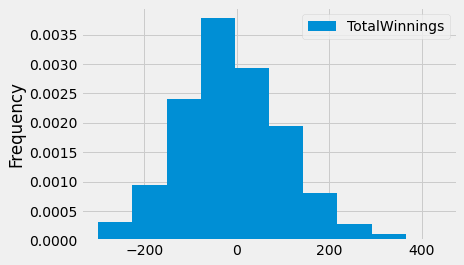

In [8]:
#: does it look normal?
bpd.DataFrame().assign(TotalWinnings=distribution).plot(kind='hist', density=True)

## Discussion question

Is the shape of this distribution explained by the Central Limit Theorem?

- A) Yes, because it is the distribution of a sample mean.
- B) Yes, because it is the distribution of a sample sum.
- C) No, because it is the distribution of money won.
- D) No, because we're not sampling from a population.

## Discussion question

How will the distribution change if the experiment were repeated, but with 400 tickets instead of 100?

- A) It will get narrower.
- B) It will get wider.
- C) It will stay the same.
- D) It will turn red.

## Answer

In [9]:
distribution_400 = np.array([])
n_repetitions = 1000

for i in np.arange(n_repetitions):
    winnings = buy_k_tickets(400).sum()
    distribution_400 = np.append(distribution_400, winnings)

## Answer

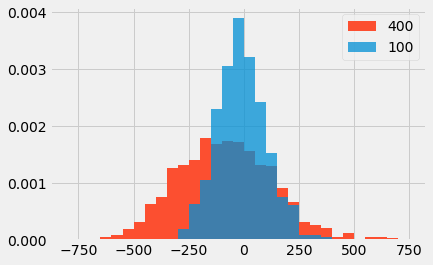

In [10]:
#: does it look normal?
bins = np.arange(-800, 800, 50)
plt.hist(distribution_400, color='C1', bins=bins, density=True, label='400');
plt.hist(distribution, bins=bins, density=True, alpha=.75, label='100');
plt.legend()

## Example: flight delays

<AxesSubplot:ylabel='Frequency'>

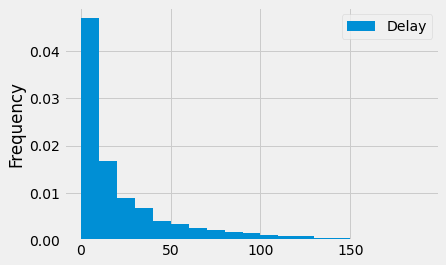

In [11]:
# the population
flights = bpd.read_csv('./data/united_summer2015.csv').get(['Delay'])
flights.plot(kind='hist', y='Delay', bins=np.arange(0, 200, 10), density=True)

In [12]:
pop_mean = flights.get('Delay').mean()
pop_mean

16.658155515370705

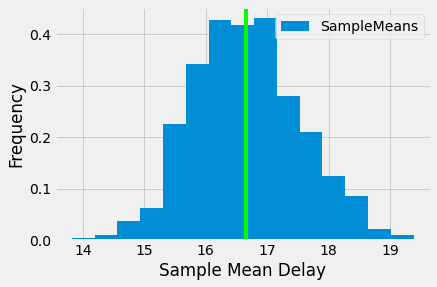

In [13]:
n_samples = 1000

sample_means = np.array([])

for i in np.arange(n_samples):
    sample = flights.sample(2000, replace=True)
    sample_mean = sample.get('Delay').mean()
    sample_means = np.append(sample_means, sample_mean)
    
bpd.DataFrame().assign(SampleMeans=sample_means).plot(kind='hist', bins=15, density=True)
plt.xlabel('Sample Mean Delay')
plt.axvline(pop_mean, color='lime')

## The shape of the distribution

- CLT: Sums and averages of random samples are roughly normal.
- Centered at population mean.
- What is the spread of the distribution?

In [14]:
#: draw `sample_size` flights, compute mean, `n_samples` times
def sample_mean_delays(sample_size, n_samples=2000):
    sample_means = np.array([])
    for i in np.arange(n_samples):
        sample = flights.sample(sample_size)
        sample_mean = sample.get('Delay').mean()
        sample_means = np.append(sample_means, sample_mean)
    return sample_means

In [15]:
#: repeat the experiment for various sample sizes
sample_means = {}
sample_sizes = [100, 200, 400, 800, 1600]

for size in sample_sizes:
    sample_means[size] = sample_mean_delays(size)

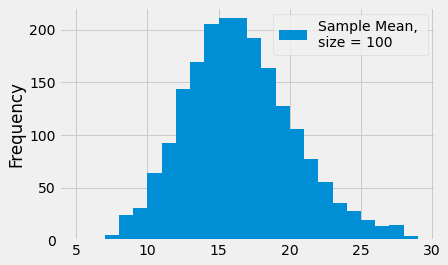

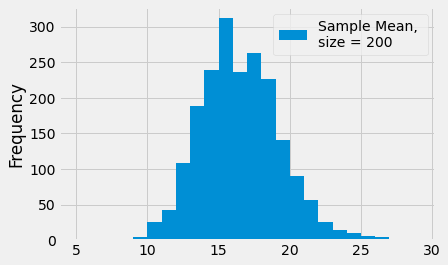

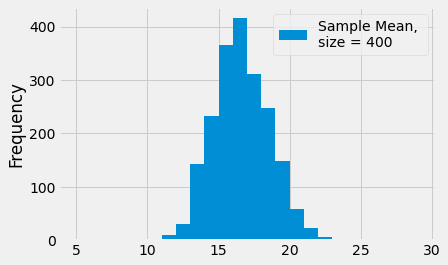

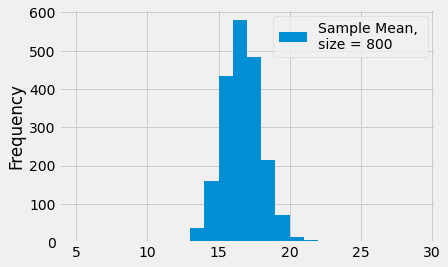

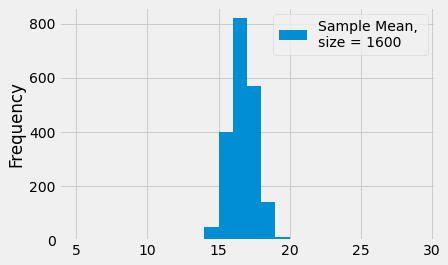

In [16]:
#: plot the distributions
bins = np.arange(5, 30)
for size in sample_sizes:
    columns = {f'Sample Mean, \nsize = {size}': sample_means[size]}
    bpd.DataFrame().assign(**columns).plot(kind='hist', bins=bins)

In [17]:
#: compute standard deviation of each distribution
sds = []
for size in sample_sizes:
    sd = np.std(sample_means[size])
    sds.append(sd)

<AxesSubplot:xlabel='SampleSize', ylabel='StandardDeviation'>

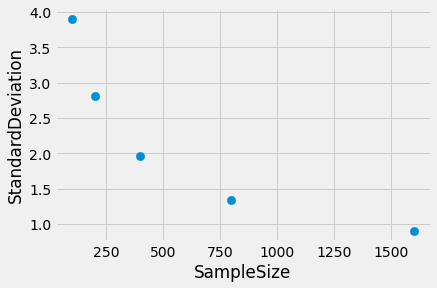

In [18]:
#: plot trend
observed = bpd.DataFrame().assign(
    SampleSize=sample_sizes,
    StandardDeviation=sds
)

observed.plot(kind='scatter', x='SampleSize', y='StandardDeviation', s=70)

## CLT for the sample mean

- Sample mean of random samples is distributed normally.
- Centered at population mean.
- Standard deviation is:
$$
    \frac{
        \text{population standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$

In [19]:
#: clt's prediction
def clt_standard_deviation(n):
    sigma = np.std(flights.get('Delay'))
    return sigma / np.sqrt(n)

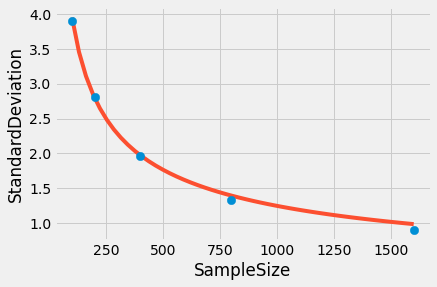

In [20]:
#: plot prediction and observed
observed.plot(kind='scatter', x='SampleSize', y='StandardDeviation', s=70, zorder=10)
x = np.linspace(100, 1600)
y = clt_standard_deviation(x)
plt.plot(x, y, color='C1')

## Recap: The Central Limit Theorem

Suppose we draw a sample of 500 flights and find the mean flight delay.

Three distributions are involved:

- The population (we don't see this)
- The sample (we see this)
- Distribution of the sample mean (we don't see this directly)
    - a.k.a, sampling distribution of mean
    - a.k.a, empirical distribution of sample mean

## The population (we don't see this)

<AxesSubplot:ylabel='Frequency'>

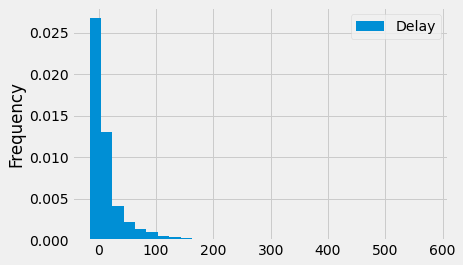

In [21]:
#:
flights = bpd.read_csv('./data/united_summer2015.csv').get(['Delay'])
flights.plot(kind='hist', y='Delay', bins=30, density=True)

## The population

- We don't see:
    - the population distribution,
    - the population mean (fixed!),
    - the population standard deviation (fixed!).

## The sample

<AxesSubplot:ylabel='Frequency'>

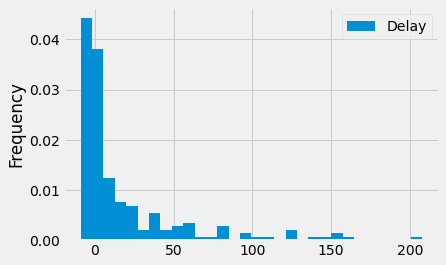

In [22]:
#:
flights.sample(200).plot(kind='hist', y='Delay', bins=30, density=True)

## The sample

- We *do* see (or can calculate):
    - the sample itself (random!),
    - the sample's mean (random!),
    - the sample's standard deviation (random!).

## CLT: Distribution of Sample Mean

- The sample mean is distributed normally.
- Centered at population mean (fixed, unobserved).
- Standard deviation (fixed, unobserved):
$$
    \frac{
        \text{population standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$

## The Central Limit Theorem

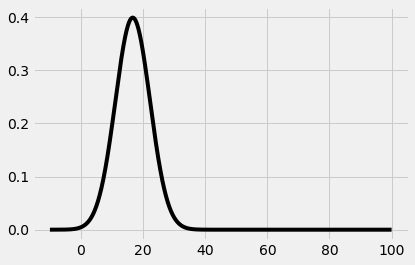

In [23]:
population_mean = flights.get('Delay').mean()
population_sd = np.std(flights.get('Delay'))

def plot_clt_curve(sample_size):
    x = np.linspace(-10, 100, 1000)
    y = normal_curve(x, population_mean, population_sd / np.sqrt(sample_size))
    plt.plot(x, y, color='black')
    
plot_clt_curve(50)

## The Central Limit Theorem

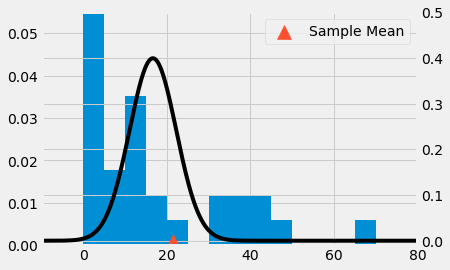

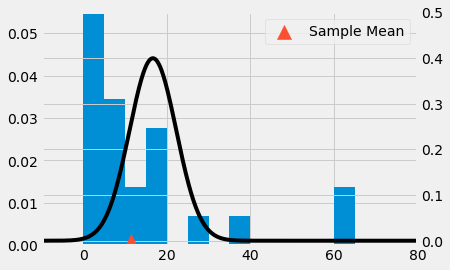

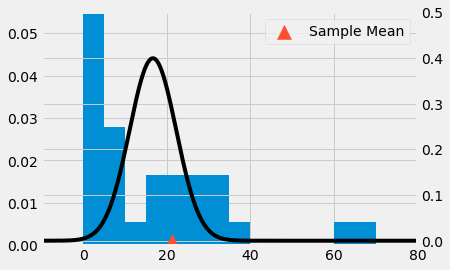

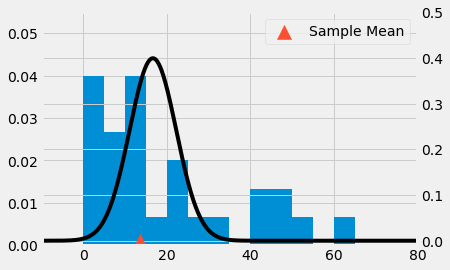

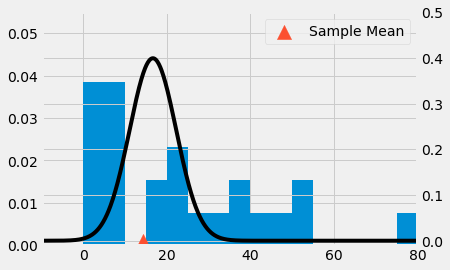

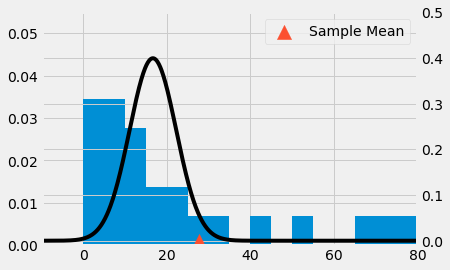

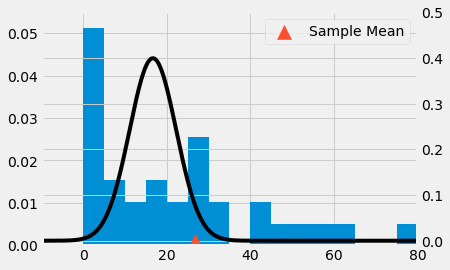

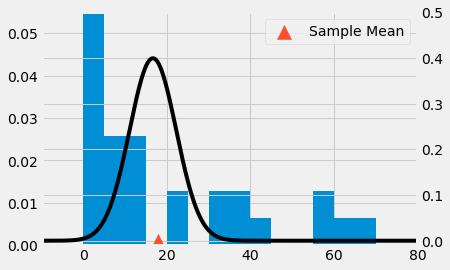

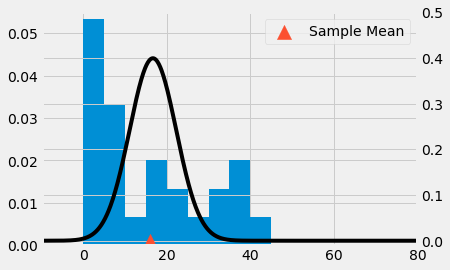

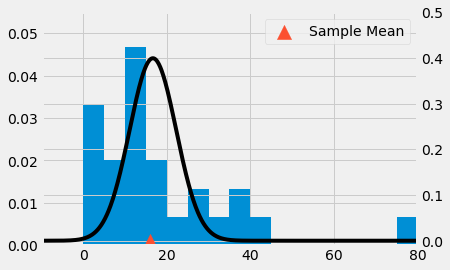

In [24]:
sample_size = 50

for i in range(10):
    plot_sample_mean(sample_size)

# Normal Confidence Intervals

## Normal confidence intervals

- We used bootstrapping to construct confidence intervals.
- But we can often use the CLT.
    - Computationally cheaper!

## Run the bootstrap

In [25]:
#: run the bootstrap for sample mean of flight delays
n_boot = 5000
np.random.seed(4)
sample = flights.sample(400)
boot_means = np.array([])

for i in np.arange(n_boot):
    resample = sample.sample(sample.shape[0], replace=True)
    boot_mean = resample.get('Delay').mean()
    boot_means = np.append(boot_means, boot_mean)

## Visualize the bootstrap

<AxesSubplot:ylabel='Frequency'>

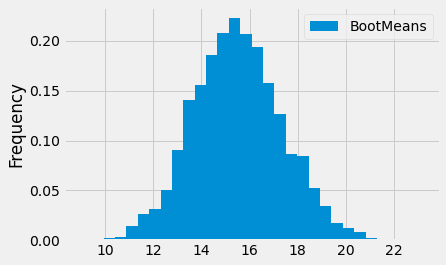

In [26]:
#: visualize
bpd.DataFrame().assign(BootMeans=boot_means).plot(kind='hist', y='BootMeans', bins=30, density=True)

## Construct 95% confidence interval

In [27]:
#: construct confidence interval
left_boot = np.percentile(boot_means, 2.5)
right_boot = np.percentile(boot_means, 97.5)
[left_boot, right_boot]

[11.9549375, 19.237687499999996]

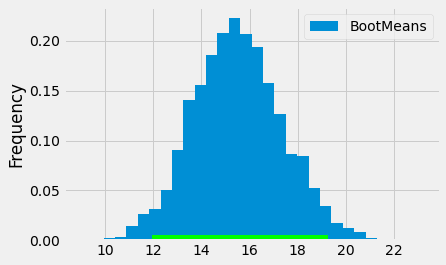

In [28]:
bpd.DataFrame().assign(BootMeans=boot_means).plot(kind='hist', y='BootMeans', bins=30, density=True)
plt.plot([left_boot, right_boot], [0, 0], color='lime', linewidth=10);

## What did the bootstrap give us?

- We use bootstrap to approximate distribution of sample mean.
- But CLT tells us it is approximately normal!
- We can use the CLT directly to construct CIs.

## Normal confidence intervals

- Draw a normal curve centered at the sample mean
- CLT tells us SD is
$$
    \frac{
        \text{population standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$
- Don't know population SD. Instead, use sample SD:
$$
    \frac{
        \text{sample standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$

## The normal curve

(array([0.00042328, 0.00084656, 0.0021164 , 0.00296296, 0.01439153,
        0.02666667, 0.03089947, 0.05037037, 0.09015873, 0.14095238,
        0.1557672 , 0.18539683, 0.20783069, 0.2226455 , 0.20698413,
        0.19386243, 0.15746032, 0.12613757, 0.08677249, 0.08465608,
        0.05206349, 0.03470899, 0.01693122, 0.01227513, 0.00804233,
        0.00253968, 0.        , 0.00169312, 0.00042328, 0.00042328]),
 array([ 9.    ,  9.4725,  9.945 , 10.4175, 10.89  , 11.3625, 11.835 ,
        12.3075, 12.78  , 13.2525, 13.725 , 14.1975, 14.67  , 15.1425,
        15.615 , 16.0875, 16.56  , 17.0325, 17.505 , 17.9775, 18.45  ,
        18.9225, 19.395 , 19.8675, 20.34  , 20.8125, 21.285 , 21.7575,
        22.23  , 22.7025, 23.175 ]),
 <BarContainer object of 30 artists>)

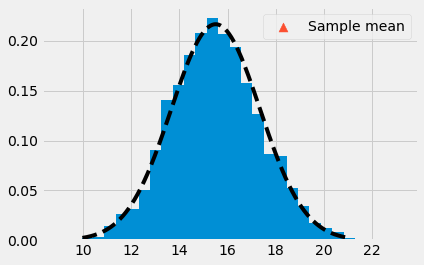

In [29]:
#: draw the normal curve
from scipy import stats
np.random.seed(4)
sample = flights.sample(400).get('Delay')
x = np.linspace(sample.mean() - 3*np.std(sample)/20, sample.mean() + 3*np.std(sample)/20, 1000)
y = stats.norm.pdf(x, sample.mean(), np.std(sample)/20)
plt.plot(x, y, color='black', linestyle='--')
plt.scatter(sample.mean(), 0, marker='^', color='C1', s=80, label='Sample mean')
plt.legend(loc='upper right')
plt.hist(boot_means, density=True, bins=30)

## Computing the confidence interval

- Recall: $\approx$ 95% of normal curve's area falls within $\pm$ 2 SDs of mean
- Don't confuse sample SD with SD of sample mean! (divide by $\sqrt{n}$)

In [30]:
#: compute confidence interval
left_normal = sample.mean() - 2*np.std(sample) / np.sqrt(400)
right_normal = sample.mean() + 2*np.std(sample) / np.sqrt(400)
[left_normal, right_normal]

[11.82279520347966, 19.19220479652034]

## Visualize the confidence interval

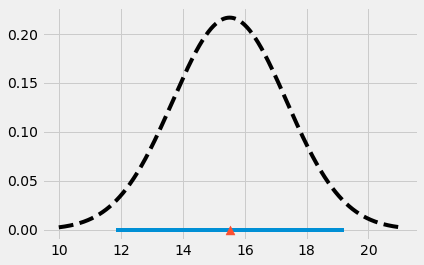

In [31]:
#:
plt.plot(x, y, color='black', linestyle='--')
plt.plot([left_normal, right_normal], [0, 0], zorder=1)
plt.scatter(sample.mean(), 0, marker='^', color='C1', zorder=2, s=80)

## Comparison with bootstrap CI

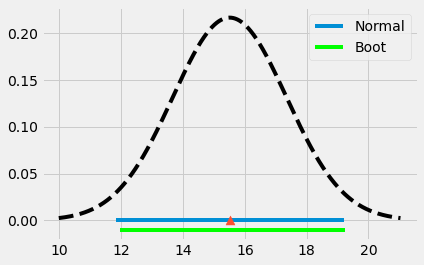

In [32]:
#:
plt.plot(x, y, color='black', linestyle='--')
plt.plot([left_normal, right_normal], [0, 0], zorder=1, label='Normal')
plt.plot([left_boot, right_boot], [-.01, -.01], color='lime', label='Boot')
plt.scatter(sample.mean(), 0, marker='^', color='C1', zorder=2, s=80)
plt.legend()

## Recap

To compute approximate 95% confidence interval for population mean:

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{n}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{n}}
\right]
$$

## So why use the bootstrap?

- We can use CLT to make CIs for:
    - sample mean
    - proportions
- But CLT doesn't apply to, for example, median.
- Have to use bootstrap there.